# Hyperparameter Tuning using HyperDrive

## Import Dependencies

In [3]:
!pip install seaborn

     |████████████████████████████████| 285 kB 7.3 MB/s eta 0:00:01


In [4]:
import os
import shutil
import seaborn as sns
import joblib
from azureml.core import Workspace, Experiment, Environment
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException
from azureml.data.dataset_factory import TabularDatasetFactory
from azureml.train.sklearn import SKLearn
from azureml.train.hyperdrive.run import PrimaryMetricGoal
from azureml.train.hyperdrive.policy import BanditPolicy
from azureml.train.hyperdrive.sampling import RandomParameterSampling
from azureml.train.hyperdrive.runconfig import HyperDriveConfig
from azureml.train.hyperdrive.parameter_expressions import choice
from azureml.widgets import RunDetails
from azureml.core.model import InferenceConfig, Model
from azureml.core.webservice.aci import AciWebservice
from azureml.core.webservice import Webservice

In [5]:
ws = Workspace.from_config()
# choose a name for experiment
experiment_name = 'wine-hyperdrive'
experiment = Experiment(ws, experiment_name)
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep = '\n')

Performing interactive authentication. Please follow the instructions on the terminal.
To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code R4MMUUQAL to authenticate.
You have logged in. Now let us find all the subscriptions to which you have access...
Interactive authentication successfully completed.
Workspace name: quick-starts-ws-137280
Azure region: southcentralus
Subscription id: 610d6e37-4747-4a20-80eb-3aad70a55f43
Resource group: aml-quickstarts-137280


In [6]:
# Create compute cluster
cpu_cluster_name = "new-cluster"
try:
    cpu_cluster = ComputeTarget(workspace=ws, name=cpu_cluster_name)
except:
    compute_config = AmlCompute.provisioning_configuration(vm_size = 'STANDARD_D2_V2', min_nodes = 1, max_nodes = 4)
    cpu_cluster = ComputeTarget.create(ws, cpu_cluster_name, compute_config)
cpu_cluster.wait_for_completion(show_output=True, min_node_count = 1, timeout_in_minutes = 10)

Creating
Succeeded.

## Dataset

### Overview 
The dataset chosen for this project can be found at https://www.kaggle.com/uciml/pima-indians-diabetes-database


It consists of several medical predictors (independent) variables and one target (dependent) variable, Outcome. Independent variables include the number of pregnancies the patient has had, their BMI, insulin level, age, and so on. The Outcome has "1" for patients who were found to have diabetes, and "0" for those who weren't.

In [8]:
# Try to load the dataset from the Workspace. Otherwise, create it from the file
found = False
key = "Winery Dataset"
description_text = "Wine Dataset for Udacity Nanodegree"

if key in ws.datasets.keys(): 
        found = True
        dataset = ws.datasets[key] 
        print("Registered dataset found in the workspace.")

if not found:
        # Register AML Dataset in Workspace
        dataset_url = "https://raw.githubusercontent.com/alihussainia/Azure3/main/wine.csv"
        ds = TabularDatasetFactory.from_delimited_files(path = dataset_url)
        dataset = ds.register(workspace=ws,
                              name=key,
                              description=description_text)
        print("Dataset registered in workspace.")

Registered dataset found in the workspace.


In [9]:
df = dataset.to_pandas_dataframe()
df.head()

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 14 columns):
name                   177 non-null int64
alcohol                177 non-null float64
malicAcid              177 non-null float64
ash                    177 non-null float64
ashalcalinity          177 non-null float64
magnesium              177 non-null int64
totalPhenols           177 non-null float64
flavanoids             177 non-null float64
nonFlavanoidPhenols    177 non-null float64
proanthocyanins        177 non-null float64
colorIntensity         177 non-null float64
hue                    177 non-null float64
od280_od315            177 non-null float64
proline                177 non-null int64
dtypes: float64(11), int64(3)
memory usage: 19.5 KB


Percentage of Classes =  0.0


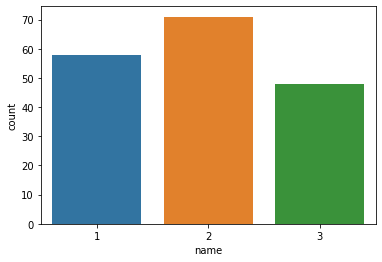

In [17]:
import seaborn as sns
sns.countplot(x='name', data=df)

# Percentages of diabetic and non-diabetic people
total = df.shape[0]
#print("Percentage of Diabetic People = ",df[df['name'] == 1].Outcome.count()/total)
print("Percentage of Classes = ",df[df['name'] == 0].name.count()/total)

## Hyperdrive Configuration

The model being used for the Hyperdrive run is a Logistic Regression model that will help predict if a patient is likely to suffer from diabetes. The hyperparameters chosen to be fine tuned are:
* Inverse of Regularization Strength "C" - This parameter was randomly sampled from a set of values (0.01, 0.1, 1, 10, 100, 1000). The C parameter controls the penalty strength, which can be effective for preventing overfitting and ensure a better generalized performance of the model.
* Maximum Iterations "max_iter"- This parameter was randomly sampled from a set of values (25, 50, 100, 150, 250). It is the Maximum number of iterations taken to converge.

In this experiment, we find that different combinations of values from the above stated parameters present us with varying levels of accuracy.

The Hyperdrive run also involves other configuration settings like an early termination policy (Bandit), a compute target to run the experiment, a primary metric for evaluation (Accuracy in this case), and maximum number of runs (20).

In [18]:
# Create an early termination policy. This is not required if using Bayesian sampling.
early_termination_policy = BanditPolicy(slack_factor = 0.1, evaluation_interval = 2)
# Create the different params for training
param_sampling = RandomParameterSampling({
    '--C': choice(0.01, 0.1, 1, 10, 100, 1000),
    '--max_iter': choice(25, 50, 100, 150, 250)
})
# Create estimator and hyperdrive config
estimator = SKLearn(source_directory = './', entry_script = 'train.py', compute_target = cpu_cluster)
hyperdrive_run_config = HyperDriveConfig(estimator = estimator,
                                     hyperparameter_sampling = param_sampling,
                                     policy = early_termination_policy,
                                     primary_metric_name = "Accuracy",
                                     primary_metric_goal = PrimaryMetricGoal.MAXIMIZE,
                                     max_total_runs = 20,
                                     max_concurrent_runs = 4)

In [13]:
# Submit run
hyperdrive_run = experiment.submit(hyperdrive_run_config)

## Run Details

The best performing model according to the HyperDrive run was a Logistic Regression model with the value of parameters "C" and "max_iter" as 100. The accuracy of this model is 0.8182

In [14]:
RunDetails(hyperdrive_run).show()

_HyperDriveWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO'…

## Best Model

In [19]:
best_run = hyperdrive_run.get_best_run_by_primary_metric()
best_run_metrics = best_run.get_metrics()
parameter_values = best_run.get_details()['runDefinition']['arguments']
print('Best Run Id: ', best_run.id)
print('Accuracy:', best_run_metrics['Accuracy'])
print('Parameter Values:', parameter_values)

Best Run Id:  HD_48deada8-4004-4bed-8e86-e5d54f82ca16_0
Accuracy: 1.0
Parameter Values: ['--C', '0.1', '--max_iter', '50']


In [20]:
model = best_run.register_model(model_name='hyperdrive', 
                                model_path='outputs/model.joblib', 
                                properties={'Accuracy': best_run_metrics['Accuracy'],
                                            'Regularization Strength': best_run_metrics['Regularization Strength:'],
                                            'Max Iterations': best_run_metrics['Max iterations:']})

In [26]:
best_run.download_file('outputs/model.joblib', 'model.joblib')

## Model Deployment

Deploying the best performing model during the HyperDrive run

In [41]:
env = Environment.from_conda_specification(name="env", file_path="environment.yml")
inference_config = InferenceConfig(entry_script='score.py', environment=env)
service_name = 'wine-prediction'
deployment_config = AciWebservice.deploy_configuration(cpu_cores = 1, memory_gb = 1)
service = Model.deploy(ws, service_name, [model], inference_config, deployment_config)
service.wait_for_deployment(show_output = True)
url = service.scoring_uri
print(service.state)
print(url)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running.......................................
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy
http://8f54af79-a4a5-425c-b1d5-3c56cb1f2fca.southcentralus.azurecontainer.io/score


Sending a request to the web service deployed to test it.

In [34]:
import json
data = {"data":
        [
            {
                "alcohol": 14.23,
                "malicAcid": 1.71,
                "ashalcalinity": 15.6,
                "magnesium": 127,
                "totalPhenols": 2.80,
                "flavanoids": 3.06,
                "nonFlavanoidPhenols": 0.28,
                "proanthocyanins": 2.29,
                "colorIntensity":5.64,
                "hue":1.04,
                "od280_od315":3.92,
                "proline":1065


            },
            {
                "alcohol": 13.16,
                "malicAcid": 2.36,
                "ashalcalinity": 18.6,
                "magnesium": 101,
                "totalPhenols": 2.80,
                "flavanoids": 3.24,
                "nonFlavanoidPhenols": 0.30,
                "proanthocyanins": 2.81,
                "colorIntensity":5.68,
                "hue":1.03,
                "od280_od315":3.17,
                "proline":1185
            }
        ]
    }
input_payload = json.dumps(data)
output = service.run(input_payload)
print(output)

[1, 1]


Printing the logs of the web service and deleting the service

In [35]:
print(service.get_logs())

2021-02-05T00:47:15,387967500+00:00 - gunicorn/run 
2021-02-05T00:47:15,388542702+00:00 - iot-server/run 
2021-02-05T00:47:15,390628311+00:00 - nginx/run 
2021-02-05T00:47:15,392394418+00:00 - rsyslog/run 
/usr/sbin/nginx: /azureml-envs/azureml_9c539d20199ae6be65c41c0382029684/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)
/usr/sbin/nginx: /azureml-envs/azureml_9c539d20199ae6be65c41c0382029684/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)
/usr/sbin/nginx: /azureml-envs/azureml_9c539d20199ae6be65c41c0382029684/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)
/usr/sbin/nginx: /azureml-envs/azureml_9c539d20199ae6be65c41c0382029684/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)
/usr/sbin/nginx: /azureml-envs/azureml_9c539d20199ae6be65c41c0382029684/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)
rsyslogd

## Implementing Standout Suggestions

Enabling Application Insights or Logging for Deployed Service

In [36]:
service.update(enable_app_insights=True)

Exporting model to ONNX format

In [37]:
from skl2onnx import convert_sklearn
import onnxmltools
from onnxmltools import convert_sklearn
from onnxmltools.utils import save_model
from onnxmltools.convert.common.data_types import *
lr_model = joblib.load('model.joblib')
initial_type = [('float_input', FloatTensorType([1, 4]))]
onnx_model = onnxmltools.convert_sklearn(lr_model,initial_types=initial_type)
save_model(onnx_model, "model.onnx")

Trying to unpickle estimator LogisticRegression from version 0.20.3 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.


Deleting the Web Service

In [38]:
service.delete()